In [1]:
# Here's the code for: The problem of a confused investor
# Assume you’re a venture capitalist and would like to figure out which start ups you should invest in.
# So you look at hundreds of start ups, and for each you write down: 
# 1. how much money they’ve already raised 
# 2. what % of their staff are engineers 
# 3. whether they’ve ultimately been successful, on a scale of 1 (most successful) to 4 (a total cluster)
# You then decide to put this info in a graph, plotting (1) money on the x-axis and (2) % engineers on the y-axis. 
# The color of each mark represents how successful they’ve been.

# This code a) builds the model, and b) shows the classification. As described in the Medium blog post, purpose of 
# this post is to show you how the neural network is created and works. I purposely haven’t gone into two very 
# important concepts: training and validation. These are absolutely critical to do if you want to be sure your 
# neural network doesn’t only work on the data you gave it. 
# Said another way, your neural network was trained only on start ups you’ve already seen. 
# You’ll be able to trust its results on  new start ups (that you haven’t yet seen) only once you validate it.

# NOTE: There are a TON of ways to make this code more efficient (for production). I've explicitly written out 
# functions to show how they work. 


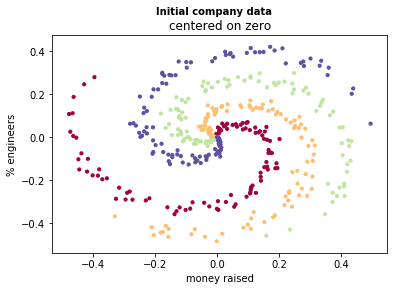

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# STEP 1: build the data points (i.e. the "start ups" in the example)

X = np.zeros([400,2], dtype = np.float32) # This has two entries: X[0] = money raised, x[1] = % engineers
Y = np.zeros(400, dtype = np.int32)       # This is the true classification of each start up (from 1 to 4)

for j in range(4):
    ind = range(j*100, (j+1)*100)
    r = np.linspace(0,1.0,100) 
    t = np.linspace(j*5,(j+1)*5, 100) + np.random.randn(100)*0.2
    X[ind] = 0.5*np.c_[r * np.sin(t), r * np.cos(t)] # The (x,y) values in a plane
    Y[ind] = j # This is the label

# Plot the figure
fig1 = plt.figure()
ax = fig1.add_subplot(111)
fig1.suptitle('Initial company data', fontsize=10, fontweight='bold')
ax.scatter(X[:,0],X[:,1], c = Y, s = 10, cmap= plt.cm.Spectral)
ax.set(title = 'centered on zero', 
       xlabel = "money raised", 
       ylabel = "% engineers")
plt.show()


In [3]:
# Now let's build a NN with TWO hidden layers

# STEP 2: Define model parameters
step_size = 1         # Step size for backpropogation (used for optimizing the neural network)
hidden_nodes1 = 100    # Size of first hidden layer
hidden_nodes2 = 50    # Size of second hidden layer
    
# STEP 3: Define the initial random weights and biases of both hidden layers
weights1 = 0.01 * np.random.randn(2,hidden_nodes1)
biases1 = np.zeros((1,hidden_nodes1))

# Hidden 1 output shape = (300 x hidden_nodes1)

weights2 = 0.01 * np.random.randn(hidden_nodes1,hidden_nodes2)
biases2 = np.zeros((1,hidden_nodes2))

# Hidden 2 output shape = (hidden_nodes1 x hidden_nodes2)

weights3 = 0.01 * np.random.randn(hidden_nodes2,4)
biases3 = np.zeros((1,4))


for i in range(6000):
    
   
    # STEP 4a: First hidden layer of the neural network
    hidden1 = np.dot(X, weights1) + biases1
    hidden1 = np.maximum(0,hidden1)    # Now add a non-linear relu function
    
    # STEP 4b: Second hidden layer of the neural network
    hidden2 = np.dot(hidden1,weights2) + biases2
    hidden2 = np.maximum(0,hidden2)    # Now add another non-linear relu function

    # STEP 4c: Add a fully connected (output) layer
    output = np.dot(hidden2, weights3) + biases3
    

    # STEP 5: Compute loss function. Note there are plenty of plug in functions you can use here. I am building one
    # (very!) manually to illustrate and break down how it works
    probs = np.ndarray(shape = output.shape)  # Initialize an array
    p2 = np.ndarray(400)

    for i in range(output.shape[0]):
        
        # First, compute the softmax function for each row of the output
        probs[i,] = np.exp(output[i,]) / np.sum(np.exp(output[i,])) 

        # Next, compute the cross-entropy for each row of the softmax. Recall the formula H(y) = -sum(y' * log(y))
        one_hot = np.zeros(4)          # Create a one-hot-vector from Y's
        one_hot[Y[i]] = 1              # This is now of the form (1,0,0) or (0,1,0) or (0,0,1)
        aa = -np.log(probs[i,]) * one_hot
        p2[i] = aa.max()               # This is the cross entropy for row i 

    # Full data loss is now the average of all of these
    data_loss = np.average(p2)

    # Add a regularization parameter to the loss function
    reg = 0.001
    loss = data_loss + 0.5*reg*np.sum(weights3**2) + 0.5*reg*np.sum(weights2**2) + 0.5*reg*np.sum(weights1**2)

    # STEP 6: Compute partial derivatives, using backpropogation (to use in parameter update)
    dloss_dy3 = probs
    for i in range(output.shape[0]):
        dloss_dy3[i,Y[i]] -= 1
    dloss_dy3 /= 400
    
    # Update weights3 and biases3
    dloss_dw3 = np.dot(hidden2.T, dloss_dy3)
    dloss_dw3 += reg*weights3
    db3 = np.sum(dloss_dy3, axis = 0, keepdims = True)
    
    # Update weights2 and biases2
    dloss_dy2 = np.dot(dloss_dy3,weights3.T)
    dloss_dy2[hidden2 <=0] = 0 # Because of relu
    db2 = np.sum(dloss_dy2, axis = 0, keepdims = True)
    dloss_dw2 = np.dot(hidden1.T, dloss_dy2)
    dloss_dw2 += reg*weights2
    
    # Update weights1 and biases 1
    dloss_dy1 = np.dot(dloss_dy2,weights2.T)
    dloss_dy1[hidden1 <=0 ] = 0 # Because of relu
    db1 = np.sum(dloss_dy1, axis = 0, keepdims = True)
    dloss_dw1 = np.dot(X.T, dloss_dy1)
    dloss_dw1 += reg*weights1
    

    # STEP 7: Now do the parameter update
    weights1 += -step_size*dloss_dw1   
    weights2 += -step_size*dloss_dw2
    weights3 += -step_size*dloss_dw3
    biases1 += -step_size*db1
    biases2 += -step_size*db2
    biases3 += -step_size*db3
 
    
print('Loss of network is ', loss)
    

Loss of network is  0.45076440697


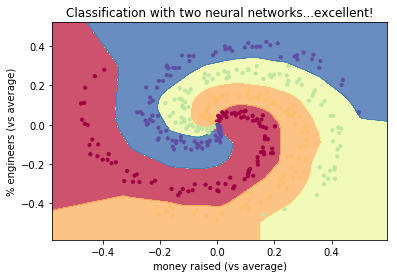

In [4]:
# STEP 8: Plot the resulting classifier
h = 0.001
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
# Build a meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xx1 = np.c_[xx.ravel(), yy.ravel()]

# Now run the meshgrid through the neural network that we've optimtized
Z1 = np.maximum(0, np.dot(xx1, weights1) + biases1)
Z2 = np.maximum(0, np.dot(Z1,weights2) + biases2)
Z3 = np.dot(Z2, weights3) + biases3

# Find the predicted class of each point
predicted_class = np.argmax(Z3, axis=1)
predicted_class = predicted_class.reshape(xx.shape)

# Plot the regions of prediction
fig5 = plt.figure()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax = fig5.add_subplot(111)
ax.contourf(xx, yy, predicted_class, cmap=plt.cm.Spectral, alpha=0.8)

# Plot the original points
ax.scatter(X[:,0],X[:,1], c = Y, s = 10, cmap= plt.cm.Spectral)
ax.set(title = 'Classification with two neural networks...excellent!', 
       xlabel = "money raised (vs average)", 
       ylabel = "% engineers (vs average)")

plt.show()


